In [ ]:
!pip install 'qiskit[visualization]'
!pip install qiskit_optimization
!pip install qiskit-terra

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from time import time
from pprint import pprint
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output

In [ ]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from qiskit_optimization import QuadraticProgram
from docplex.mp.model import Model

In [ ]:
from qiskit.optimization.applications.ising import stable_set
from qiskit import Aer
from qiskit.optimization.applications.ising import stable_set
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, QAOA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/__init__.py:86: DeprecationWarning:

The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>

/usr/local/lib/python3.7/dist-packages/qiskit/optimization/__init__.py:92: DeprecationWarning:

The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>



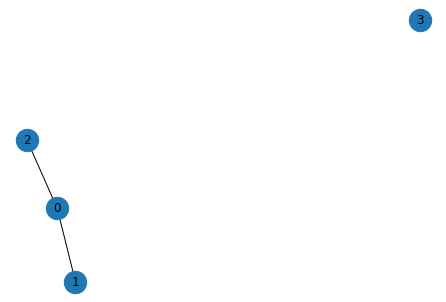

In [ ]:
G1 = nx.Graph()
G1_nodes_list = [0,1,2,3]
G1_edges_list = [(0,1), (0,2)]
G1.add_nodes_from(G1_nodes_list)
G1.add_edges_from(G1_edges_list)
nx.draw(G1, with_labels=True, alpha=1, node_size=500)

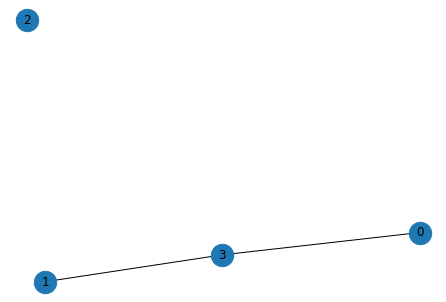

In [ ]:
G2 = nx.Graph()
G2_nodes_list = [0,1,2,3]
G2_edges_list = [(0,3), (1,3)]
G2.add_nodes_from(G2_nodes_list)
G2.add_edges_from(G2_edges_list)
nx.draw(G2, with_labels=True, alpha=1, node_size=500)

In [ ]:
# print(G1.degree(3))
# print(G2.degree(3))
nx.is_isomorphic(G1,G2)

True

In [ ]:
def qubo_matrix_generator(G1,G2):
    qubo = QuadraticProgram()

    # QUBO Problem definition 
    for v in G2.nodes: 
        for i in G1.nodes: 
            # print('Degree at v = %d: %d\t Degree at i = %d\t: %d '%(v,G2.degree(int(v)),i, G1.degree(int(i))))
            if (G2.degree(int(v)) == G1.degree(int(i))) and G1.degree(int(i))>0 : 
                # Define the qubo variables
                qubo.binary_var(f'x_{int(v)},{int(i)}')

    
    QUBO_matrix_size = qubo.get_num_binary_vars()
    QUBO_binary_variables_list = qubo.variables
    ij_list = [ ( variable.name ).split('_')[-1].split(',') for variable in QUBO_binary_variables_list ]
    ij_list = [ [ int(i) for i in ij ] for ij in ij_list ]
    # print(ij_list)
    # for variable in QUBO_binary_variables_list: 
    #     print(variable.name)

    # Intialilise the QUBO matrix
    QUBO_matrix = np.zeros((QUBO_matrix_size, QUBO_matrix_size))
    variable_tuple_list = []

    # for tuple_variable1 in QUBO_binary_variables_list: 
        # for tuple_variable2 not tuple_variable1 in QUBO_binary_variables_list:
        #     # variable_tuple_list.
        # print(tuple_variable1)
    ij_to_1 = []
    different_qubo_variables = []
    for [u , i] in ij_list:
        for [v , j] in ij_list:
            if [ u, i ] != [ v, j ]:
                different_qubo_variables += [  ([ u, i ], [ v, j ])  ]

    for ([ u, i ], [ v, j ]) in different_qubo_variables:
            # print(f"u: {u}, i: {i}, v: {v}, j: {j}")
            if i == j:
                name = f"x_{u},{i}"
                variable_ui = qubo.get_variable(name)
                variable_ui = 1
                
                name = f"x_{v},{j}"
                variable_vj = qubo.get_variable(name)
                variable_vj = 1

                ij_to_1 += [ [ (u, i), (v, j) ] ]

            elif u == v:
                name = f"x_{u},{i}"
                variable_ui = qubo.get_variable(name)
                variable_ui = 1
                
                name = f"x_{v},{j}"
                variable_vj = qubo.get_variable(name)
                variable_vj = 1

                ij_to_1 += [ [ (u, i), (v, j) ] ]

            elif not G1.has_edge(i, j) == G2.has_edge(u, v):
                name = f"x_{u},{i}"
                variable_ui = qubo.get_variable(name)
                variable_ui = 1
                
                name = f"x_{v},{j}"
                variable_vj = qubo.get_variable(name)
                variable_vj = 1

                ij_to_1 += [ [ (u, i), (v, j) ] ]

    for i in range(QUBO_matrix_size):
        QUBO_matrix[i][i] = -1
        
    for (i, j) in ij_list:
        QUBO_matrix[i][j] = 1

    # print(ij_list)

    matrix_test = np.zeros((QUBO_matrix_size, QUBO_matrix_size))
    # pprint(ij_to_1)
    ij_to_1_dict = {}

    for (row, col) in ij_to_1:
        row = list(row)
        col = list(col)
        i = ij_list.index(row)
        j = ij_list.index(col)
        ij_to_1_dict[ (i,j) ] = (row, col)
        matrix_test[i][j] = 1

    for row in range(QUBO_matrix_size): 
      for column in range(QUBO_matrix_size): 
         matrix_test[row][row] = -1
    
    QUBO_matrix_final = np.triu(matrix_test)
    QUBO_matrix_upper = np.triu(matrix_test)
    QUBO_matrix_lower = np.tril(matrix_test)
    
    # print(QUBO_matrix_lower)
    
    # Convert to upper triangular
    for i in range(QUBO_matrix_size):
      for j in range(QUBO_matrix_size): 
        if ((i>j) and (not matrix_test[i][j] == 0)): 
          matrix_test[i][j] = matrix_test[i][j] + matrix_test[j][i]
          matrix_test[i][j] = 0
    


    # pprint(ij_to_1_dict)
    # print(QUBO_matrix_final)






    return matrix_test

In [ ]:
QUBO_Matrix = qubo_matrix_generator(G1,G2)

print(QUBO_Matrix)
# Once we get the matrix, we now generate the corresponding Ising Model
qubitOp, offset = stable_set.get_operator(QUBO_Matrix)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

[[-1.  1.  1.  0.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.]]
Offset: -0.5
Ising Hamiltonian:
IIIZZ	(0.5+0j)
IIZIZ	(0.5+0j)
IZIZI	(0.5+0j)
IZZII	(0.5+0j)
IIIIZ	(-1+0j)
IIIZI	(-0.5+0j)
IIZII	(-0.5+0j)



In [ ]:
QUBO_Matrix = qubo_matrix_generator(G1,G2)

qubitOp, offset = stable_set.get_operator(QUBO_Matrix)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

qaoa = QAOA(quantum_instance=quantum_instance, p = 3)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
result = qaoa_optimizer.solve(qp)
print(result)

Offset: -0.5
Ising Hamiltonian:
IIIZZ	(0.5+0j)
IIZIZ	(0.5+0j)
IZIZI	(0.5+0j)
IZZII	(0.5+0j)
IIIIZ	(-1+0j)
IIIZI	(-0.5+0j)
IIZII	(-0.5+0j)

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

minimize
 [ 2 x_0*x_1 + 2 x_0*x_2 - x_1^2 + 2 x_1*x_3 - x_2^2 + 2 x_2*x_3 - 2 x_3^2 ]
 -0.500000;
 
subject to {

}
optimal function value: -2.5
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS


In [ ]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

minimize
 [ 2 x_0*x_1 + 2 x_0*x_2 - x_1^2 + 2 x_1*x_3 - x_2^2 + 2 x_2*x_3 - 2 x_3^2 ]
 -0.500000;
 
subject to {

}


In [ ]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

qaoa = QAOA(quantum_instance=quantum_instance, p =1)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)


In [ ]:
# solve quadratic program
result = qaoa_optimizer.solve(qp)
print(result)

optimal function value: -2.5
optimal value: [1. 0. 0. 1. 1.]
status: SUCCESS


In [ ]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#quadratic optimization
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo

# Prepare QUBO task

# Lucas's QUBO


In [ ]:
import networkx as nx
import sys , math

In [ ]:
def generateQUBO(G1 , G2):
  n = G1.order()
  print(n)
  varsDict = {}
  index = 0
  for i in range(n):
    for j in range(n):
      varsDict[(i,j)] = index
      index += 1

  # initialize Q
  Q = {}
  for i in range(n*n):
    for j in range(n*n): 
      Q[i,j] = 0

  # HA part 1
  for i in range(n):
    for iprime in range(n):
      index = varsDict[(i, iprime )]
      Q[index , index ] -= 2
  
  for iprime1 in range(n):
    for iprime2 in range(n):
      index1 = varsDict[(i, iprime1 )]
      index2 = varsDict [(i, iprime2 )]
      Q[ index1 , index2 ] += 1

  # HA part 2
  for iprime in range(n):
    for i in range(n):
      index = varsDict[(i, iprime )]
      Q[index , index ] -= 2

  for i1 in range(n):
    for i2 in range(n):
      index1 = varsDict[(i1 , iprime )]
      index2 = varsDict[(i2 , iprime )]
      Q[ index1 , index2 ] += 1
  
  # HB part 1
  for i in range(n):
    for j in range(n):
      if i in G1[j]: continue
      for (u,v) in G2.edges():
        x1= varsDict[(u,i)]
        x2= varsDict[(v,j)]
        Q[x1 ,x2] += 1
        x1= varsDict[(v,i)]
        x2= varsDict[(u,j)]
        Q[x1 ,x2] += 1

  # HB part 2
  for (i,j) in G1.edges():
    for u in range(n):
      for v in range(n):
        if u in G2[v]: continue
        x1= varsDict[(u,i)]
        x2= varsDict[(v,j)]
        Q[x1 ,x2] += 1
        x1= varsDict[(u,j)]
        x2= varsDict[(v,i)]
        Q[x1 ,x2] += 1
  
  # Making Q uppertriangular
  for i in range(n*n):
    for j in range(n*n):
      if (i > j) and ( not (Q[i,j ]==0) ):
        Q[j,i] += Q[i,j]
        Q[i,j] = 0

  print(n*n)
  for i in range(n*n):
    for j in range(n*n):
      print(Q[i,j], end =' ')
    print()

  return Q


In [ ]:
generateQUBO(G1,G2)

4
16
-4 2 2 0 0 2 2 0 0 2 2 0 2 0 0 2 
0 -4 0 0 2 0 0 0 2 0 0 0 0 2 2 2 
0 0 -4 0 2 0 0 0 2 0 0 0 0 2 2 2 
0 0 0 -3 0 0 0 2 0 0 0 2 2 2 2 4 
0 0 0 0 -4 2 2 0 0 2 2 0 2 0 0 2 
0 0 0 0 0 -4 0 0 2 0 0 0 0 2 2 2 
0 0 0 0 0 0 -4 0 2 0 0 0 0 2 2 2 
0 0 0 0 0 0 0 -3 0 0 0 2 2 2 2 4 
0 0 0 0 0 0 0 0 -4 2 2 0 0 2 2 0 
0 0 0 0 0 0 0 0 0 -4 0 0 2 0 0 0 
0 0 0 0 0 0 0 0 0 0 -4 0 2 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 -3 0 0 0 2 
0 0 0 0 0 0 0 0 0 0 0 0 -3 4 4 2 
0 0 0 0 0 0 0 0 0 0 0 0 0 -3 2 2 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -3 2 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -2 


{(0, 0): -4,
 (0, 1): 2,
 (0, 2): 2,
 (0, 3): 0,
 (0, 4): 0,
 (0, 5): 2,
 (0, 6): 2,
 (0, 7): 0,
 (0, 8): 0,
 (0, 9): 2,
 (0, 10): 2,
 (0, 11): 0,
 (0, 12): 2,
 (0, 13): 0,
 (0, 14): 0,
 (0, 15): 2,
 (1, 0): 0,
 (1, 1): -4,
 (1, 2): 0,
 (1, 3): 0,
 (1, 4): 2,
 (1, 5): 0,
 (1, 6): 0,
 (1, 7): 0,
 (1, 8): 2,
 (1, 9): 0,
 (1, 10): 0,
 (1, 11): 0,
 (1, 12): 0,
 (1, 13): 2,
 (1, 14): 2,
 (1, 15): 2,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): -4,
 (2, 3): 0,
 (2, 4): 2,
 (2, 5): 0,
 (2, 6): 0,
 (2, 7): 0,
 (2, 8): 2,
 (2, 9): 0,
 (2, 10): 0,
 (2, 11): 0,
 (2, 12): 0,
 (2, 13): 2,
 (2, 14): 2,
 (2, 15): 2,
 (3, 0): 0,
 (3, 1): 0,
 (3, 2): 0,
 (3, 3): -3,
 (3, 4): 0,
 (3, 5): 0,
 (3, 6): 0,
 (3, 7): 2,
 (3, 8): 0,
 (3, 9): 0,
 (3, 10): 0,
 (3, 11): 2,
 (3, 12): 2,
 (3, 13): 2,
 (3, 14): 2,
 (3, 15): 4,
 (4, 0): 0,
 (4, 1): 0,
 (4, 2): 0,
 (4, 3): 0,
 (4, 4): -4,
 (4, 5): 2,
 (4, 6): 2,
 (4, 7): 0,
 (4, 8): 0,
 (4, 9): 2,
 (4, 10): 2,
 (4, 11): 0,
 (4, 12): 2,
 (4, 13): 0,
 (4, 14): 0,
 (4, 15): 2,
 (5, 